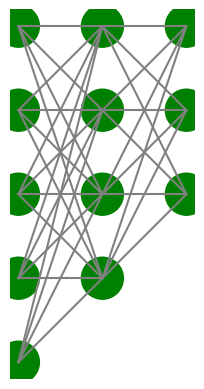

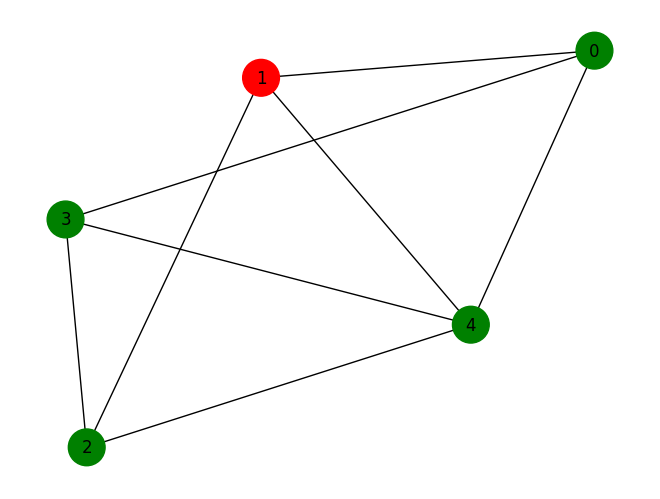

NameError: name 'GNWModel' is not defined

In [5]:
import matplotlib.pyplot as plt
import networkx as nx
import random

class SimpleFeedforwardNetwork:
    def __init__(self, layers=[5, 3, 2]):
        self.layers = layers
        self.activations = [[False] * size for size in layers]

    def activate_input_layer(self, stimulus=True):
        # Activate all nodes in the input layer if stimulus is True
        self.activations[0] = [stimulus] * self.layers[0]
        # Propagate activation to subsequent layers
        for i in range(1, len(self.layers)):
            self.activations[i] = [any(self.activations[i-1])] * self.layers[i]

    def reset_activations(self):
        self.activations = [[False] * size for size in self.layers]
    
    def draw_network(self):
        fig, ax = plt.subplots()
        total_layers = len(self.layers)
        max_layer_size = max(self.layers)
        
        for i, layer_size in enumerate(self.layers):
            for j in range(layer_size):
                node_color = 'green' if self.activations[i][j] else 'red'
                circle = plt.Circle((i * 2, (max_layer_size - j * 2)), 0.5, color=node_color)
                ax.add_artist(circle)
                if i < total_layers - 1:
                    for k in range(self.layers[i+1]):
                        ax.plot([i * 2, (i + 1) * 2], [(max_layer_size - j * 2), (max_layer_size - k * 2)], 'gray')
        
        plt.axis('scaled')
        plt.axis('off')
        plt.show()

class SimpleGNWModel:
    def __init__(self, num_nodes=5):
        self.num_nodes = num_nodes
        self.network = nx.erdos_renyi_graph(n=num_nodes, p=0.5)
        self.activations = {node: False for node in self.network.nodes}

    def activate_node(self, stimulus=True):
        if stimulus:
            selected_node = random.choice(list(self.network.nodes))
            self.activations[selected_node] = True

            # Simulate global broadcast
            for neighbor in self.network.neighbors(selected_node):
                self.activations[neighbor] = True
        else:
            # Keep current activations to simulate persistence
            pass

    def reset_activations(self):
        self.activations = {node: False for node in self.network.nodes}

    def draw_network(self):
        color_map = ['green' if self.activations[node] else 'red' for node in self.network.nodes]
        nx.draw(self.network, node_color=color_map, with_labels=True, node_size=700)
        plt.show()

# Initialize networks
feedforward_net = SimpleFeedforwardNetwork(layers=[5, 4, 3])
gnw_net = SimpleGNWModel(num_nodes=5)

# Activate and draw initial state
feedforward_net.activate_input_layer(stimulus=True)
gnw_net.activate_node(stimulus=True)

feedforward_net.draw_network()
gnw_net.draw_network()

import matplotlib.pyplot as plt

def simulate_time_passing(network, steps=10):
    """
    Simulate the network updating for a number of steps without new input.
    For the GNW model, this would involve internal feedback mechanisms.
    For the feedforward network, activity is expected to quickly fade.
    """
    # Placeholder for collecting activity data
    activity_over_time = []
    
    # Simulating time passing
    for step in range(steps):
        if isinstance(network, GNWModel):
            # For GNW, simulate feedback maintaining or modulating activity
            _, activity = network(None, feedback=True)  # Simplified representation
        else:
            # For the feedforward network, there's no mechanism to maintain activity without input
            activity = torch.zeros_like(network.layer2.weight)  # Assuming activity can be represented by layer weights
        
        activity_over_time.append(activity.mean().item())
    
    return activity_over_time

def plot_activity_over_time(feedforward_activity, gnw_activity):
    """
    Plots the activity over time for both networks.
    """
    plt.figure(figsize=(10, 6))
    plt.plot(feedforward_activity, label='Feedforward Network Activity')
    plt.plot(gnw_activity, label='GNW Model Activity')
    plt.xlabel('Time Steps')
    plt.ylabel('Average Activity')
    plt.title('Network Activity Over Time After Stimulus Removal')
    plt.legend()
    plt.show()

# Example usage (assuming networks have been defined and simulated):
feedforward_activity = simulate_time_passing(feedforward_net)
gnw_activity = simulate_time_passing(gnw_net)

plot_activity_over_time(feedforward_activity, gnw_activity)